Power-spectrum estimation with LASSO

In [5]:
import numpy as np
import matplotlib.pyplot as plt

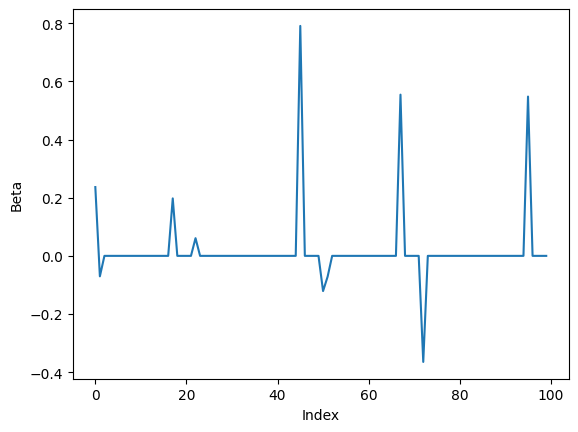

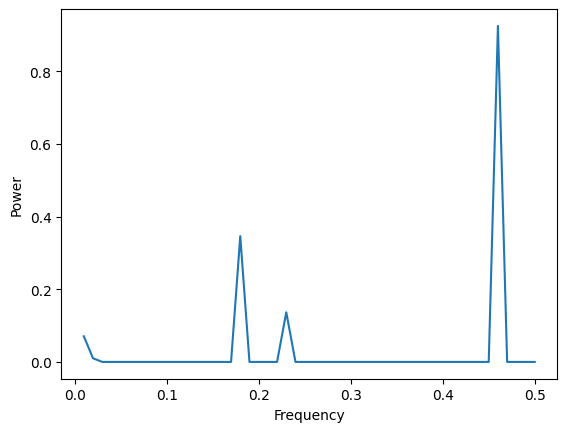

In [6]:
# Generate data
M = 50  # Number of frequencies (the number of coefficients is 2M)
K = 0.1  # Fraction of non-zero coefficients

nu = np.linspace(0.5/M, 0.5, M)    # Frequency
nozeros = np.random.choice(M, size=int(K*M), replace=False)    # Indices of non-zero coefficients
phase = 2*np.pi*np.random.rand(len(nozeros))     # Phase
ampl = np.random.rand(len(nozeros))     # Amplitude
beta = np.zeros(2*M)     # Fourier coefficients (initially sparse)
beta[nozeros] = ampl*np.cos(phase)    # Non-zero cos coefficients
beta[nozeros+M] = ampl*np.sin(phase)     # Non-zero sin coefficients

# Plot the Fourier coefficients (beta)
plt.plot(beta)
plt.xlabel('Index')
plt.ylabel('Beta')
plt.show()
# Plot the power spectrum
power = beta[0:M]**2 + beta[M:2*M]**2     # Powers
plt.plot(nu, power)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

$$
\begin{pmatrix}
y_1\\
y_2\\
\vdots\\
y_N
\end{pmatrix} =
\begin{pmatrix}
\cos(2\pi t_1 \nu_1) & \cos(2\pi t_1 \nu_2) & \cdots & \cos(2\pi t_1 \nu_M) \\
\cos(2\pi t_2 \nu_1) & \cos(2\pi t_2 \nu_2) & \cdots & \cos(2\pi t_2 \nu_M) \\
\vdots & \vdots & & \vdots\\
\cos(2\pi t_N \nu_1) & \cos(2\pi t_N \nu_2) & \cdots & \cos(2\pi t_N \nu_M)
\end{pmatrix}
\begin{pmatrix}
\beta_1\\
\beta_2\\
\vdots \\
\beta_M
\end{pmatrix}
+\mathcal{N}(0,\sigma)
$$

$$
\mathbf{y}=\mathcal{F}\mathbf{\beta}
$$

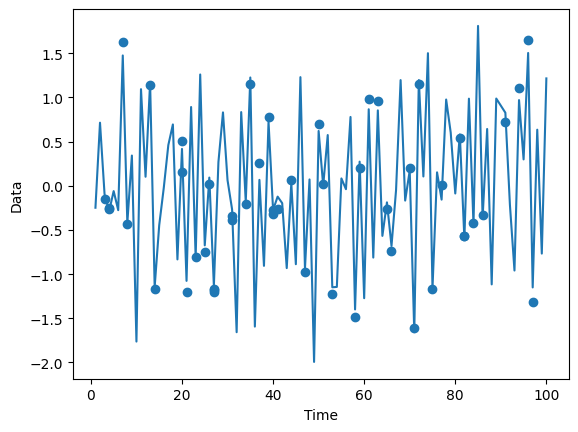

In [7]:
# Complete data
t0 = np.linspace(1, 2*M, 2*M)
F0 = np.hstack([np.cos(2*np.pi*np.outer(t0,nu)), np.sin(2*np.pi*np.outer(t0,nu))])     # Inverse Fourier basis functions
y0 = F0 @ beta     # Time-domain data generated from the Fourier coefficients

# Random sampling
N = 50   # Number of observations
sigma = 0.1   # Standard deviation of Gaussian noise
obs_window = np.random.choice(2*M, size=N, replace=True)    # Randomly sampled indices for observations
t = t0[obs_window]     # Observed time points
y = y0[obs_window] + np.random.normal(0, sigma, N)     # Observed data + Gaussian noise
F = np.hstack([np.cos(2*np.pi*np.outer(t,nu)),np.sin(2*np.pi*np.outer(t,nu))])     # Fourier basis functions for observed time points

plt.plot(t0, y0)
plt.scatter(t, y)
plt.xlabel('Time')
plt.ylabel('Data')
plt.show()

The Fourier coefficients $\beta$ (2M) are estimated with the data $\mathbf{y}$ (N < 2M) and the matrix $\mathcal{F}$ with LASSO.

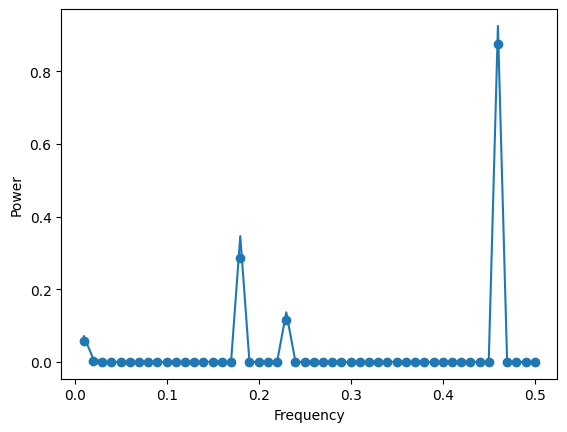

In [8]:
from sklearn.linear_model import Lasso
results = Lasso(fit_intercept=True, alpha=0.01).fit(F,y)     # LASSO regression
p = results.coef_[0:M]**2 + results.coef_[M:2*M]**2     # Power spectrum

plt.plot(nu, power)
plt.scatter(nu, p)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

Exercise
1. Change the non-zero fraction (K), and regularization coefficient of LASSO (alpha), then compare the results.
2. Assuming a very small noise (sigma), can you completely estimate the 2M coefficients from smaller N (<2M) data?

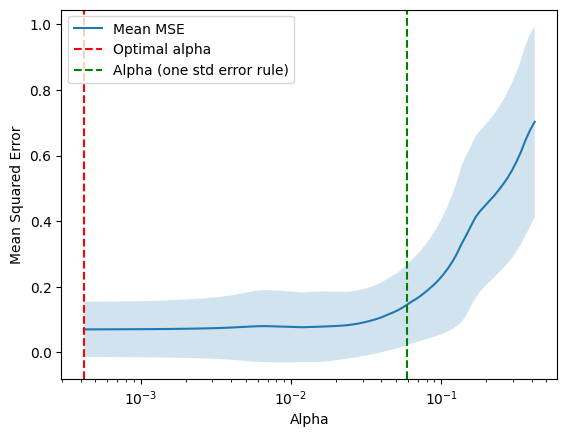

0.0004193974178213908 0.05944850037600395


In [9]:
# Cross-validation to determine the regularization coefficient (alpha)
from sklearn.linear_model import LassoCV

cvs = LassoCV(fit_intercept=True, cv=5).fit(F,y)

# Extract results
alphas = cvs.alphas_
mean_mse = cvs.mse_path_.mean(axis=1)
std_mse = cvs.mse_path_.std(axis=1)

# Best alpha based on minimum mean MSE
best_alpha = cvs.alpha_
best_mse = mean_mse[np.argmin(mean_mse)]

# Apply the one-standard-error rule to select alpha
one_std_error_threshold = best_mse + std_mse[np.argmin(mean_mse)]
alpha_one_std_error = alphas[np.where(mean_mse <= one_std_error_threshold)[0][0]]

plt.semilogx(alphas, mean_mse, label='Mean MSE')
plt.fill_between(alphas, mean_mse - std_mse, mean_mse + std_mse, alpha=0.2)
plt.axvline(cvs.alpha_, linestyle='--', color='red', label='Optimal alpha')
plt.axvline(alpha_one_std_error, linestyle='--', color='green', label='Alpha (one std error rule)')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

print(best_alpha, alpha_one_std_error)

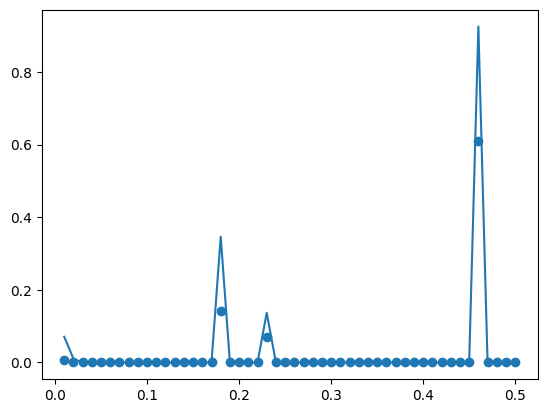

In [10]:
# LASSO regression with alpha_one_std_error
results = Lasso(fit_intercept=True, alpha=alpha_one_std_error).fit(F,y)     # LASSO regression
p = results.coef_[0:M]**2 + results.coef_[M:2*M]**2     # Power spectrum
plt.plot(nu, power)
plt.scatter(nu, p)

Exercise
3. Perform LASSO regression with best_alpha, and compare the result with alpha_one_std_error.